In [1]:
#!pip install neuralprophet

In [37]:
# import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from neuralprophet import NeuralProphet

In [38]:
# load dataset from csv
df = pd.read_csv('users.csv')
df = df[:-1]
df.tail()

,date,users,users_2,users_7,users_30
257,2021-08-14,617,1246.0,4666.0,20600.0
258,2021-08-15,577,1194.0,4448.0,20609.0
259,2021-08-16,637,1214.0,4405.0,20629.0
260,2021-08-17,611,1248.0,4367.0,20759.0
261,2021-08-18,582,1193.0,4266.0,20607.0


### Case 1: XGBoost

In [39]:
# create train and test data
features = ['users_2', 'users_7', 'users_30']
label = ['users']
train_df = df[(df['date'] < '2021-07-01')]
test_df = df[df['date'] >= '2021-07-01']
X_train, y_train = train_df[features], train_df[label]
X_test, y_test = test_df[features], test_df[label]

In [40]:
# train xgboost model
reg = XGBRegressor(n_estimators=500, learning_rate=0.01)
reg.fit(X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric=['mae'])
evals_result = reg.evals_result()

[04:02:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:651.69	validation_1-mae:688.135
[1]	validation_0-mae:645.403	validation_1-mae:681.368
[2]	validation_0-mae:639.181	validation_1-mae:674.666
[3]	validation_0-mae:633.018	validation_1-mae:668.03
[4]	validation_0-mae:626.917	validation_1-mae:661.458
[5]	validation_0-mae:620.873	validation_1-mae:654.974
[6]	validation_0-mae:614.903	validation_1-mae:648.53
[7]	validation_0-mae:608.996	validation_1-mae:642.148
[8]	validation_0-mae:603.143	validation_1-mae:635.851
[9]	validation_0-mae:597.35	validation_1-mae:629.593
[10]	validation_0-mae:591.61	validation_1-mae:623.418
[11]	validation_0-mae:585.928	validation_1-mae:617.274
[12]	validation_0-mae:580.302	validation_1-mae:611.196
[13]	validation_0-mae:574.731	validation_1-mae:605.171
[14]	validation_0-mae:569.219	validation_1-mae:599.179
[15]	validation_0-mae:563.755	validation_1-mae:593.271
[16]	val

Text(0.5, 1.0, 'Mean Absolute Error of XGBoost Model by Estimator')

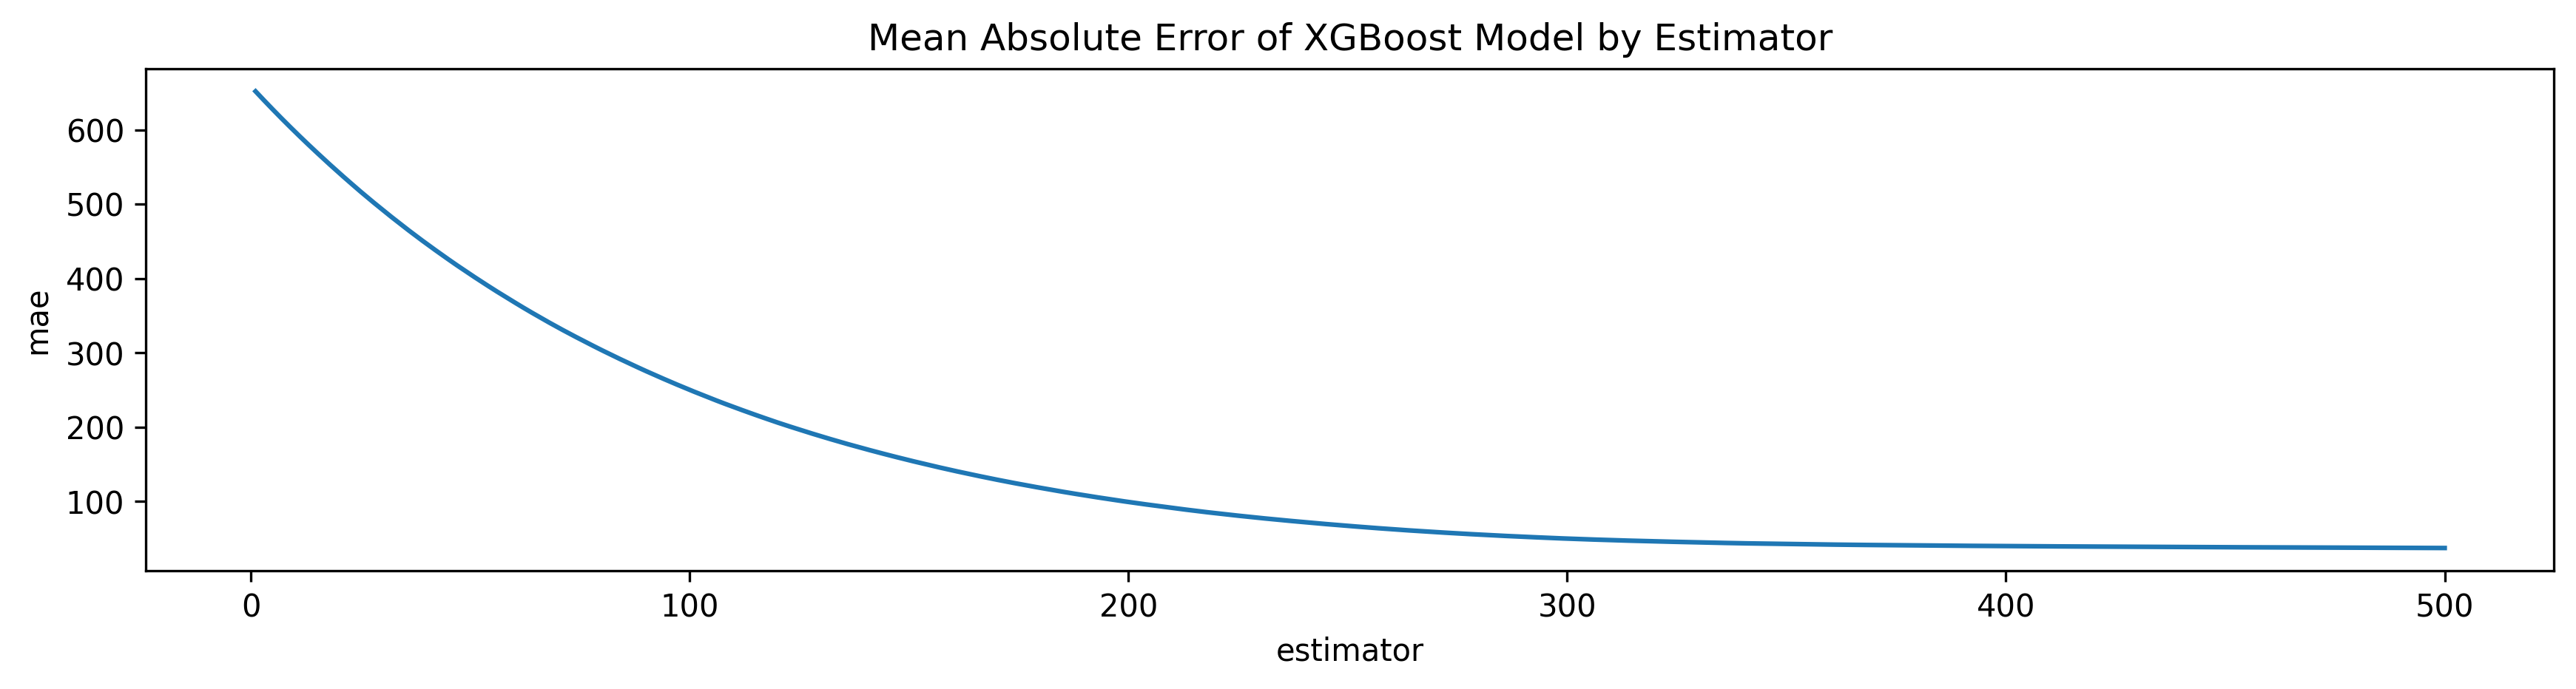

In [41]:
# plot mean absolute error of xgboost model
plt.close()
mae_range = range(1, len(evals_result['validation_0']['mae'])+1)
mae_xgb  = pd.DataFrame()
mae_xgb['estimator'] = mae_range 
mae_xgb['mae'] = evals_result['validation_0']['mae']
plt.rcParams.update({'figure.figsize': (14, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=mae_xgb, x='estimator', y='mae')
plt.title("Mean Absolute Error of XGBoost Model by Estimator")

In [42]:
# forecast using xgboost model on testing data
predictions = reg.predict(X_test)

In [43]:
# add predictions to test dataframe
test_df = test_df.reset_index().drop('index', axis=1)
test_df['predictions'] = pd.Series(predictions)
test_df.head()

,date,users,users_2,users_7,users_30,predictions
0,2021-07-01,741,1564.0,6377.0,31385.0,758.651794
1,2021-07-02,884,1625.0,6337.0,31470.0,776.239136
2,2021-07-03,810,1694.0,5951.0,31480.0,864.050720
3,2021-07-04,905,1715.0,5970.0,31139.0,864.050720
4,2021-07-05,776,1681.0,5893.0,30748.0,864.050720


Text(0.5, 1.0, 'Forecasting the Number of Unique Users in AAVE (xgboost)')

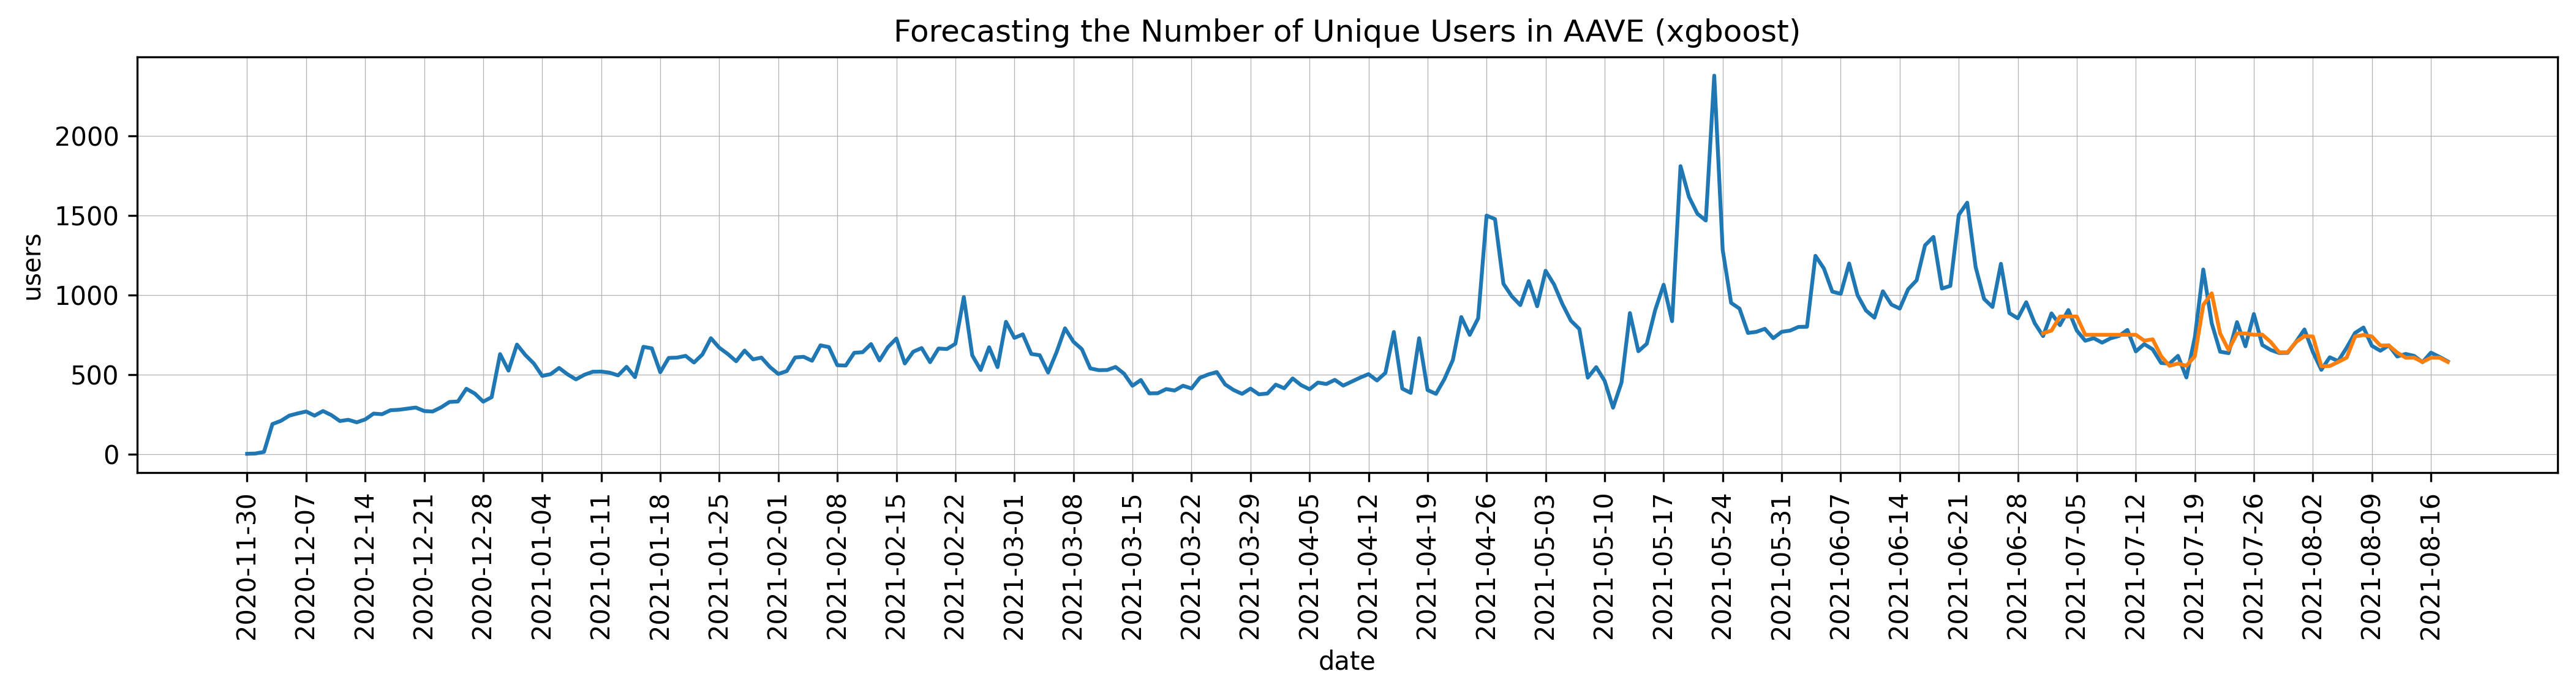

In [44]:
# plot the forecast with the actual values
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=df, x='date', y='users')
sns.lineplot(data=test_df, x='date', y='predictions')
ax.set_xticks(ax.get_xticks()[::7])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)
plt.title("Forecasting the Number of Unique Users in AAVE (xgboost)")

In [45]:
plt.close()

### Case 2: NeuralProphet

In [46]:
# create the train data
prophet_train = df[(df['date'] < '2021-07-01')]
prophet_train = prophet_train[['date', 'users']]
prophet_train = prophet_train.rename(columns={'date': 'ds', 'users': 'y'})
prophet_train.tail()

,ds,y
208,2021-06-26,1196
209,2021-06-27,886
210,2021-06-28,853
211,2021-06-29,954
212,2021-06-30,823


In [47]:
# fit the neuralprohpet model, choose 4000 epochs because it's struggling to fit
p = NeuralProphet()
prophet = p.fit(prophet_train, freq='D', epochs=4000)

INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 6.58E-01
Epoch[4000/4000]: 100%|██████████| 4000/4000 [03:22<00:00, 19.80it/s, SmoothL1Loss=0.0126, MAE=131, RegLoss=0]


Text(0.5, 1.0, 'Mean Absolute Error of NeuralProphet Model by Epoch')

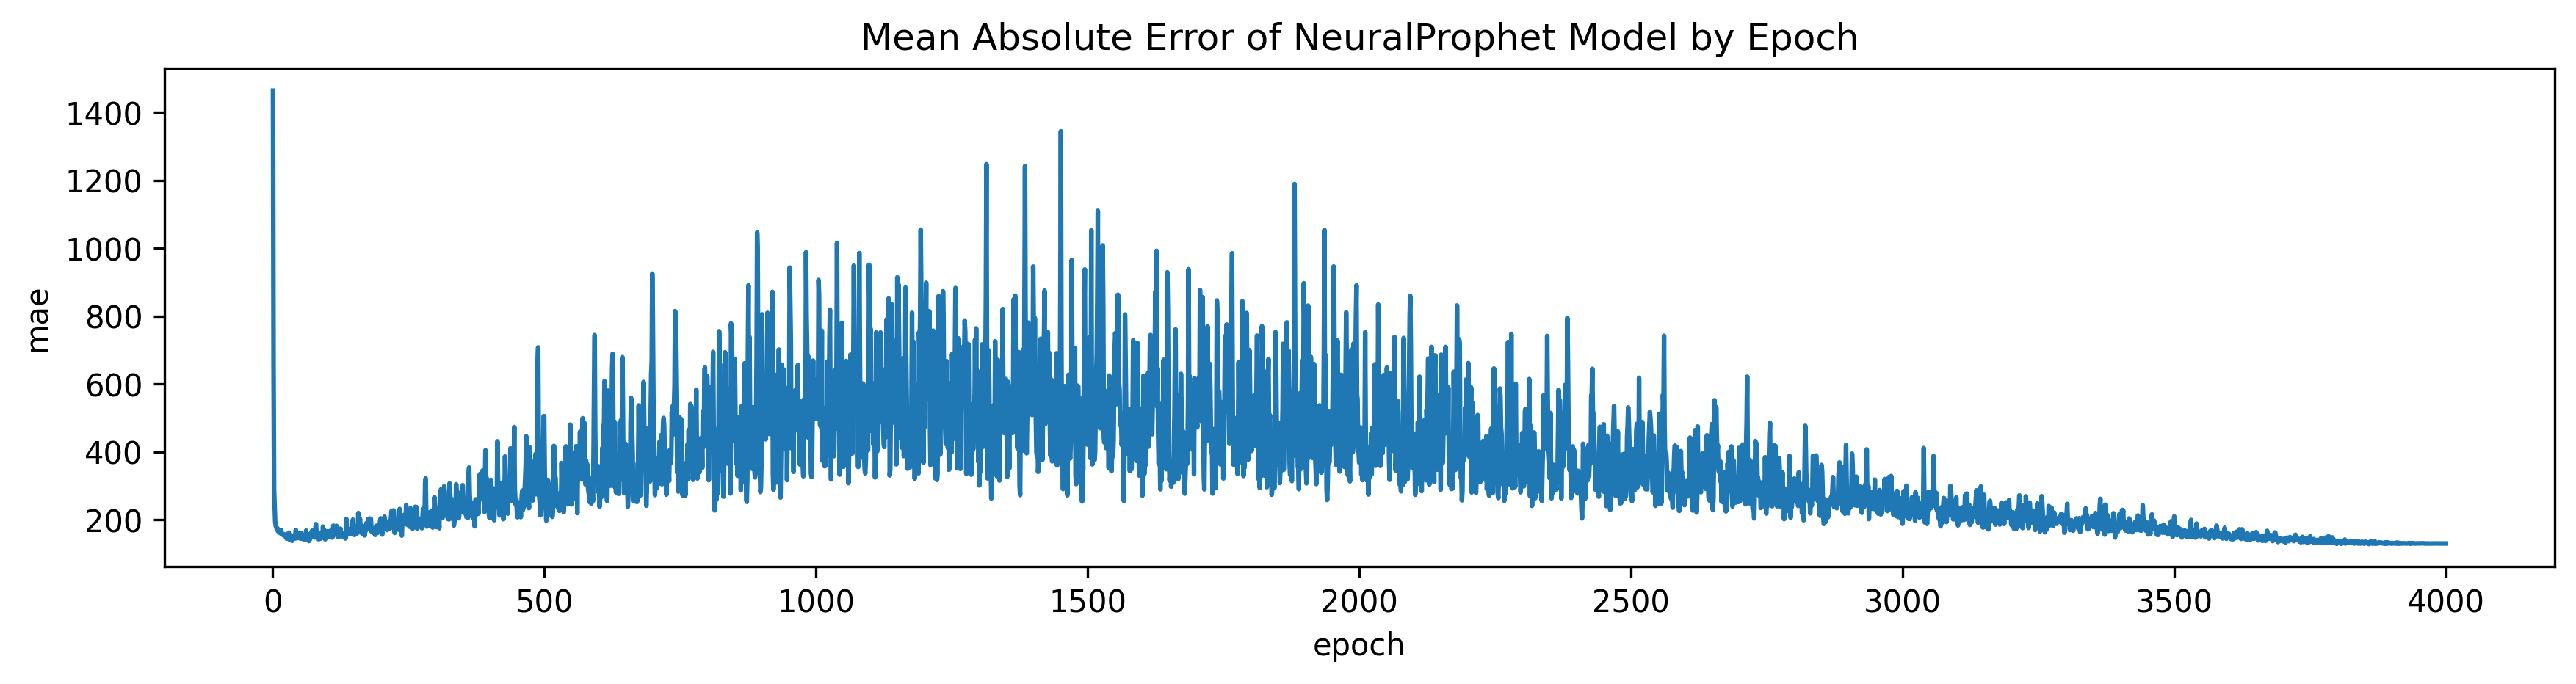

In [48]:
# plot mean absolute error of neuralprohpet model
plt.close()
np_range = range(1, len(prophet['MAE'])+1)
mae_np  = pd.DataFrame()
mae_np['epoch'] = np_range
mae_np['mae'] = prophet['MAE']
plt.rcParams.update({'figure.figsize': (14, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=mae_np, x='epoch', y='mae')
plt.title("Mean Absolute Error of NeuralProphet Model by Epoch")

In [49]:
# create testing dataframe
future = p.make_future_dataframe(prophet_train, periods=49)
# forecast neuralprophet model
prophet_test = p.predict(future)
prophet_test['ds'] = prophet_test['ds'].astype('string')
prophet_test.tail()

,ds,y,yhat1,residual1,trend,season_weekly
44,2021-08-14,None,1437.772461,NaN,1443.392090,-5.619606
45,2021-08-15,None,1480.448730,NaN,1449.432129,31.016590
46,2021-08-16,None,1454.859497,NaN,1455.472534,-0.613088
47,2021-08-17,None,1454.135620,NaN,1461.512207,-7.376626
48,2021-08-18,None,1452.481079,NaN,1467.552490,-15.071540


Text(0.5, 1.0, 'Forecasting the Number of Unique Users in AAVE (neuralprophet)')

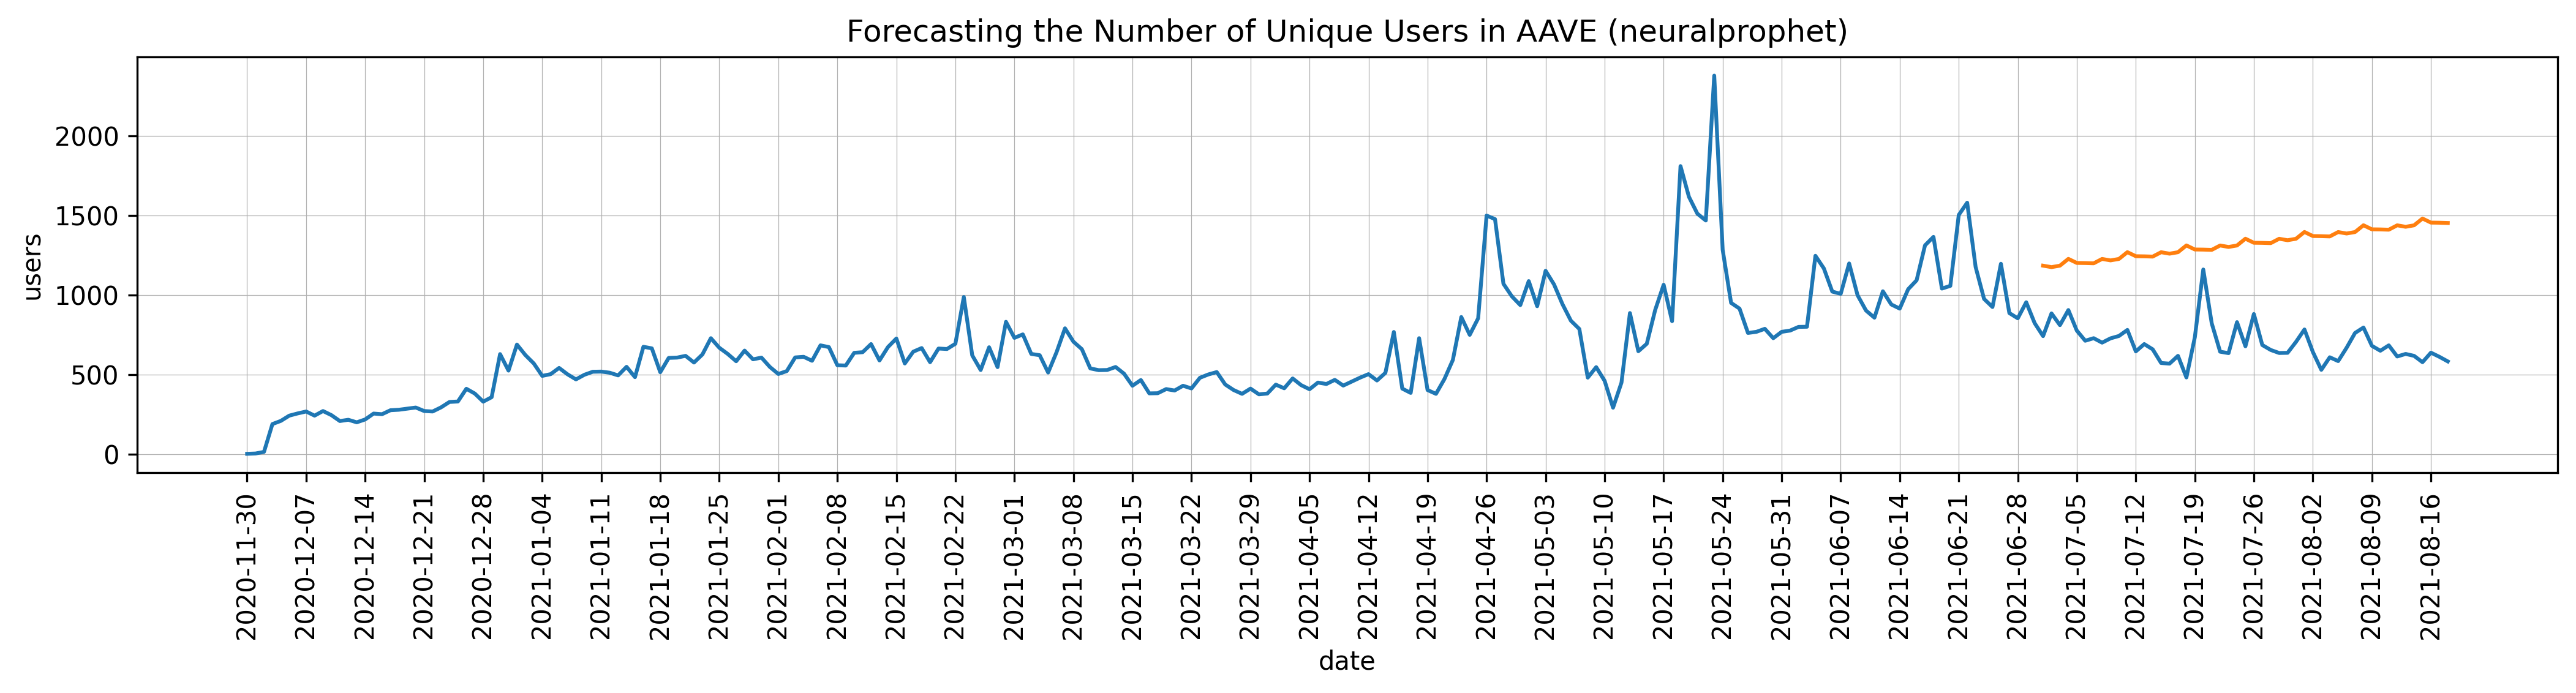

In [50]:
# plot the forecast with the actual values
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=df, x='date', y='users')
sns.lineplot(data=prophet_test, x='ds', y='yhat1')
ax.set_xticks(ax.get_xticks()[::7])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)
plt.title("Forecasting the Number of Unique Users in AAVE (neuralprophet)")